# Classifying Turkish Songs into Emotions

## Introduction

Music can drastically affect our everyday lives. When listening to music, oftentimes, it causes an emotional response from the listener. These emotions that we feel regularly dictate our lives. Emotions are very complex so categorizing them is difficult (Er et al., 2021). In a study from 2020, researchers found that there are about thirteen different emotions that are felt when we listen to music. This was determined by getting participants to listen to various songs and quantitatively determine the percentage of each of the emotions they felt in a percentage equalling 100%. Many of the emotions that we feel are a mixture of different feelings that we experience. You are able to capture most of these emotions using the thirteen emotions. These emotions included Amusing, Annoying, Anxious, Beautiful, Relaxing, Dreamy, Energizing, Erotic, Indignant, Joyful, Sad, Scary, and Triumphant (Cowen et al., 2020). In this project, we will classify songs into the following emotions: 

- Happy: the feeling of pleasure
- Sad: the feeling of unhappiness
- Angry: The strong feeling of dislike towards something
- Relaxed: The feeling of being calm (Oxford)

The study of linking music to emotions is still being explored today. Through this project, we aim to further explore this topic by investigating how different elements of music can be associated with emotions, and how we can use these elements to classify the primary emotion of a song. The data set “Turkish Music Emotion” by Mehmet Bilal Er explores this question. He used fifty variables over 400 Turkish songs and categorized each song into one of four emotions: Happy, Sad, Angry, and Relaxed. 

From Mehmet Bilal Er’s dataset, six variables were selected to act as predictors in this report: 
- Low Energy Mean: percentage of frames with less energy than usual
- Zero Crossing Rate Mean: times the waveform crosses zero
- Attack Time Mean: peaks passed through the compressor
- Pulse Clarity Mean: how easily the song’s rhythm can be perceived
- Spectral Spread Mean: standard deviation of spectral centroid
- Harmonic Change Detection Function Mean: key and chord transitions

With this, we hypothesize that the average Low Energy, Zero Crossing Rate, Attack Time, Pulse Clarity, Spectral Spread, and Harmonic Change Detection will be able to accurately predict the main emotion of a song, Happy, Sad, Angry, and Relaxed, using the K-nearest neighbors classification algorithm.

## Methods: Data Analysis

### Load the necessary packages

In [1]:
library(tidyverse)
library(tidymodels)
library(repr)
library(GGally)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

### Load the data from the original source
Below, we can observe that the original data set was tidy, for each row is a single observation, a Turkish song. Additionally, each column is a single variable, and each value is a single cell.
We also sliced rows 1 to 10 to take a snapshot of the full data since the full data is too big to display.

In [2]:
turkish_data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00638/Acoustic%20Features.csv")
turkish_data |> slice(1:10)

Rows: 400 Columns: 51
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): Class
dbl (50): _RMSenergy_Mean, _Lowenergy_Mean, _Fluctuation_Mean, _Tempo_Mean, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Class,_RMSenergy_Mean,_Lowenergy_Mean,_Fluctuation_Mean,_Tempo_Mean,_MFCC_Mean_1,_MFCC_Mean_2,_MFCC_Mean_3,_MFCC_Mean_4,_MFCC_Mean_5,⋯,_Chromagram_Mean_9,_Chromagram_Mean_10,_Chromagram_Mean_11,_Chromagram_Mean_12,_HarmonicChangeDetectionFunction_Mean,_HarmonicChangeDetectionFunction_Std,_HarmonicChangeDetectionFunction_Slope,_HarmonicChangeDetectionFunction_PeriodFreq,_HarmonicChangeDetectionFunction_PeriodAmp,_HarmonicChangeDetectionFunction_PeriodEntropy
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
relax,0.052,0.591,9.136,130.043,3.997,0.363,0.887,0.078,0.221,⋯,0.426,1.000,0.008,0.101,0.316,0.261,0.018,1.035,0.593,0.970
relax,0.125,0.439,6.680,142.240,4.058,0.516,0.785,0.397,0.556,⋯,0.002,1.000,0.000,0.984,0.285,0.211,-0.082,3.364,0.702,0.967
relax,0.046,0.639,10.578,188.154,2.775,0.903,0.502,0.329,0.287,⋯,0.184,0.746,0.016,1.000,0.413,0.299,0.134,1.682,0.692,0.963
relax,0.135,0.603,10.442,65.991,2.841,1.552,0.612,0.351,0.011,⋯,0.038,1.000,0.161,0.757,0.422,0.265,0.042,0.354,0.743,0.968
relax,0.066,0.591,9.769,88.890,3.217,0.228,0.814,0.096,0.434,⋯,0.004,0.404,1.000,0.001,0.345,0.261,0.089,0.748,0.674,0.957
relax,0.137,0.510,7.664,116.044,2.313,-0.082,0.365,0.033,-0.136,⋯,0.064,0.391,0.102,0.000,0.280,0.240,0.355,1.682,0.662,0.958
relax,0.123,0.533,7.483,136.444,4.572,1.171,0.939,0.358,0.024,⋯,0.000,1.000,0.000,0.143,0.210,0.174,0.193,2.691,0.691,0.966
relax,0.103,0.575,7.006,141.132,3.495,0.553,0.275,0.269,0.257,⋯,0.128,1.000,0.030,0.746,0.366,0.267,-0.061,0.585,0.711,0.965
relax,0.145,0.542,6.846,82.048,4.010,0.550,0.568,0.559,0.218,⋯,0.000,0.150,0.910,0.000,0.322,0.210,0.031,0.408,0.796,0.970


*Figure 1: First 10 rows of the original data set*

### Wrangle and clean the data
Here, we wrangled the data by renaming all the columns by removing the extra underscore, making the column names more human readable.

In [3]:
colnames(turkish_data) <- c("Class", "RMS_Energy_Mean", "Low_Energy_Mean", "Fluctuation_Mean", "Tempo_Mean", 
                            "MFCC_Mean1", "MFCC_Mean2", "MFCC_Mean3", "MFCC_Mean4", "MFCC_Mean5", "MFCC_Mean6",
                            "MFCC_Mean7", "MFCC_Mean8", "MFCC_Mean9", "MFCC_Mean10", "MFCC_Mean11", "MFCC_Mean12",
                            "MFCC_Mean13", "Roughness_Mean", "Roughness_Slope", "Zero_Crossing_Rate_Mean",
                            "Attack_Time_Mean", "Attack_Time_Slope", "Roll_Off_Mean", "Event_Density_Mean", "Pulse_Clarity_Mean",
                            "Brightness_Mean", "Spectral_Centroid_Mean", "Spectral_Spread_Mean", "Spectral_Skewness_Mean",
                            "Spectral_Kurtosis_Mean", "Spectral_Flatness_Mean", "Entropy_of_Spectrum_Mean", "Chromagram_Mean1",
                            "Chromagram_Mean2", "Chromagram_Mean3", "Chromagram_Mean4", "Chromagram_Mean5", "Chromagram_Mean6",
                            "Chromagram_Mean7", "Chromagram_Mean8", "Chromagram_Mean9", "Chromagram_Mean10", "Chromagram_Mean11",
                            "Chromagram_Mean12", "Harmonic_Change_Detection_Function_Mean", "Harmonic_Change_Detection_Function_Std",
                            "Harmonic_Change_Detection_Function_Slope", "Harmonic_Change_Detection_Function_Period_Freq", 
                            "Harmonic_Change_Detection_Function_Period_Amp", "Harmonic_Change_Detection_Function_Period_Entropy")


Then, we notice that our categorical variable, Class, is a character type, so we convert it to a factor type. We again slice rows 1 to glimpse the first few observations.

In [4]:
turkish_data <- mutate(turkish_data, Class = as_factor(Class))
turkish_data |> slice(1:10)

Class,RMS_Energy_Mean,Low_Energy_Mean,Fluctuation_Mean,Tempo_Mean,MFCC_Mean1,MFCC_Mean2,MFCC_Mean3,MFCC_Mean4,MFCC_Mean5,⋯,Chromagram_Mean9,Chromagram_Mean10,Chromagram_Mean11,Chromagram_Mean12,Harmonic_Change_Detection_Function_Mean,Harmonic_Change_Detection_Function_Std,Harmonic_Change_Detection_Function_Slope,Harmonic_Change_Detection_Function_Period_Freq,Harmonic_Change_Detection_Function_Period_Amp,Harmonic_Change_Detection_Function_Period_Entropy
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
relax,0.052,0.591,9.136,130.043,3.997,0.363,0.887,0.078,0.221,⋯,0.426,1.000,0.008,0.101,0.316,0.261,0.018,1.035,0.593,0.970
relax,0.125,0.439,6.680,142.240,4.058,0.516,0.785,0.397,0.556,⋯,0.002,1.000,0.000,0.984,0.285,0.211,-0.082,3.364,0.702,0.967
relax,0.046,0.639,10.578,188.154,2.775,0.903,0.502,0.329,0.287,⋯,0.184,0.746,0.016,1.000,0.413,0.299,0.134,1.682,0.692,0.963
relax,0.135,0.603,10.442,65.991,2.841,1.552,0.612,0.351,0.011,⋯,0.038,1.000,0.161,0.757,0.422,0.265,0.042,0.354,0.743,0.968
relax,0.066,0.591,9.769,88.890,3.217,0.228,0.814,0.096,0.434,⋯,0.004,0.404,1.000,0.001,0.345,0.261,0.089,0.748,0.674,0.957
relax,0.137,0.510,7.664,116.044,2.313,-0.082,0.365,0.033,-0.136,⋯,0.064,0.391,0.102,0.000,0.280,0.240,0.355,1.682,0.662,0.958
relax,0.123,0.533,7.483,136.444,4.572,1.171,0.939,0.358,0.024,⋯,0.000,1.000,0.000,0.143,0.210,0.174,0.193,2.691,0.691,0.966
relax,0.103,0.575,7.006,141.132,3.495,0.553,0.275,0.269,0.257,⋯,0.128,1.000,0.030,0.746,0.366,0.267,-0.061,0.585,0.711,0.965
relax,0.145,0.542,6.846,82.048,4.010,0.550,0.568,0.559,0.218,⋯,0.000,0.150,0.910,0.000,0.322,0.210,0.031,0.408,0.796,0.970


*Figure 2: Data set with more human readable column names*

### K-nn Classification

We split the turkish data set into a training set (80%) and a testing set (20%). This way, we can build the classifier using training data and test the prediction accuracy of our classifier using the testing data. Moreover, we set the strata argument to Class so that the testing and training set has a balanced number of each Class. Since the initial_split function involves randomness, we set a seed so that it is reproducible. 

In [5]:
set.seed(6969)

turkish_split <- initial_split(turkish_data, prop = 0.8, strata = Class)
turkish_training <- training(turkish_split)
turkish_testing <- training(turkish_split)

#### Select the predictors variables

Below in Figure 3, we visualized our predictor variables using ggpairs() to scope the shape and spread of our predictors plotted against each other. We set colour = Class in order to visually see how the spreads in each emotion were affected by each variable. Observing the plots, we can see that most predictor variables are not very correlated with one another, and many of the plots show areas where you can distinguish the Class (ie. an area consisting mostly of one color). This suggests that they will be meaningful and non-redundant predictors.

- We chose Low Energy and Zero Crossing Rate as predictors because after plotting Zero Crossing Rate against Low Energy, the songs with the highest Zero Crossing Rate were generally labeled as happy songs for example, for the green colored observations are located towards the top of the plot.
- We also chose Attack Time and Pulse Clarity as predictors because after plotting Pulse Clarity against Attack Time, the songs with the highest Pulse Clarity mean were generally labeled as happy songs for example.
- Lastly, we chose Spectral Spread and Harmonic Change Detection Function as predictors because after plotting Harmonic Change Detection Function against Spectral Spread, the songs with the lowest Harmonic Change Detection Function are generally labeled as angry songs, for most of the purple data points are located below the other points.

In addition to quantitative characteristics, we chose these variables because they are intrinsic to giving music emotion. Harmonic Change Detection Function reveals distinction in texture, pace and style features, Spectral spread indicates how distinguishable notes are from each other, and Attack Time is associated with rhythmic emphasis — all of which are factors that vary greatly across different music emotions. Moreover, low energy tends to be associated with sad songs, while pulse clarity is often associated with sad songs. Lastly, zero crossing rate is often associated with the noisiness of music, which is another useful discriminator of emotion.

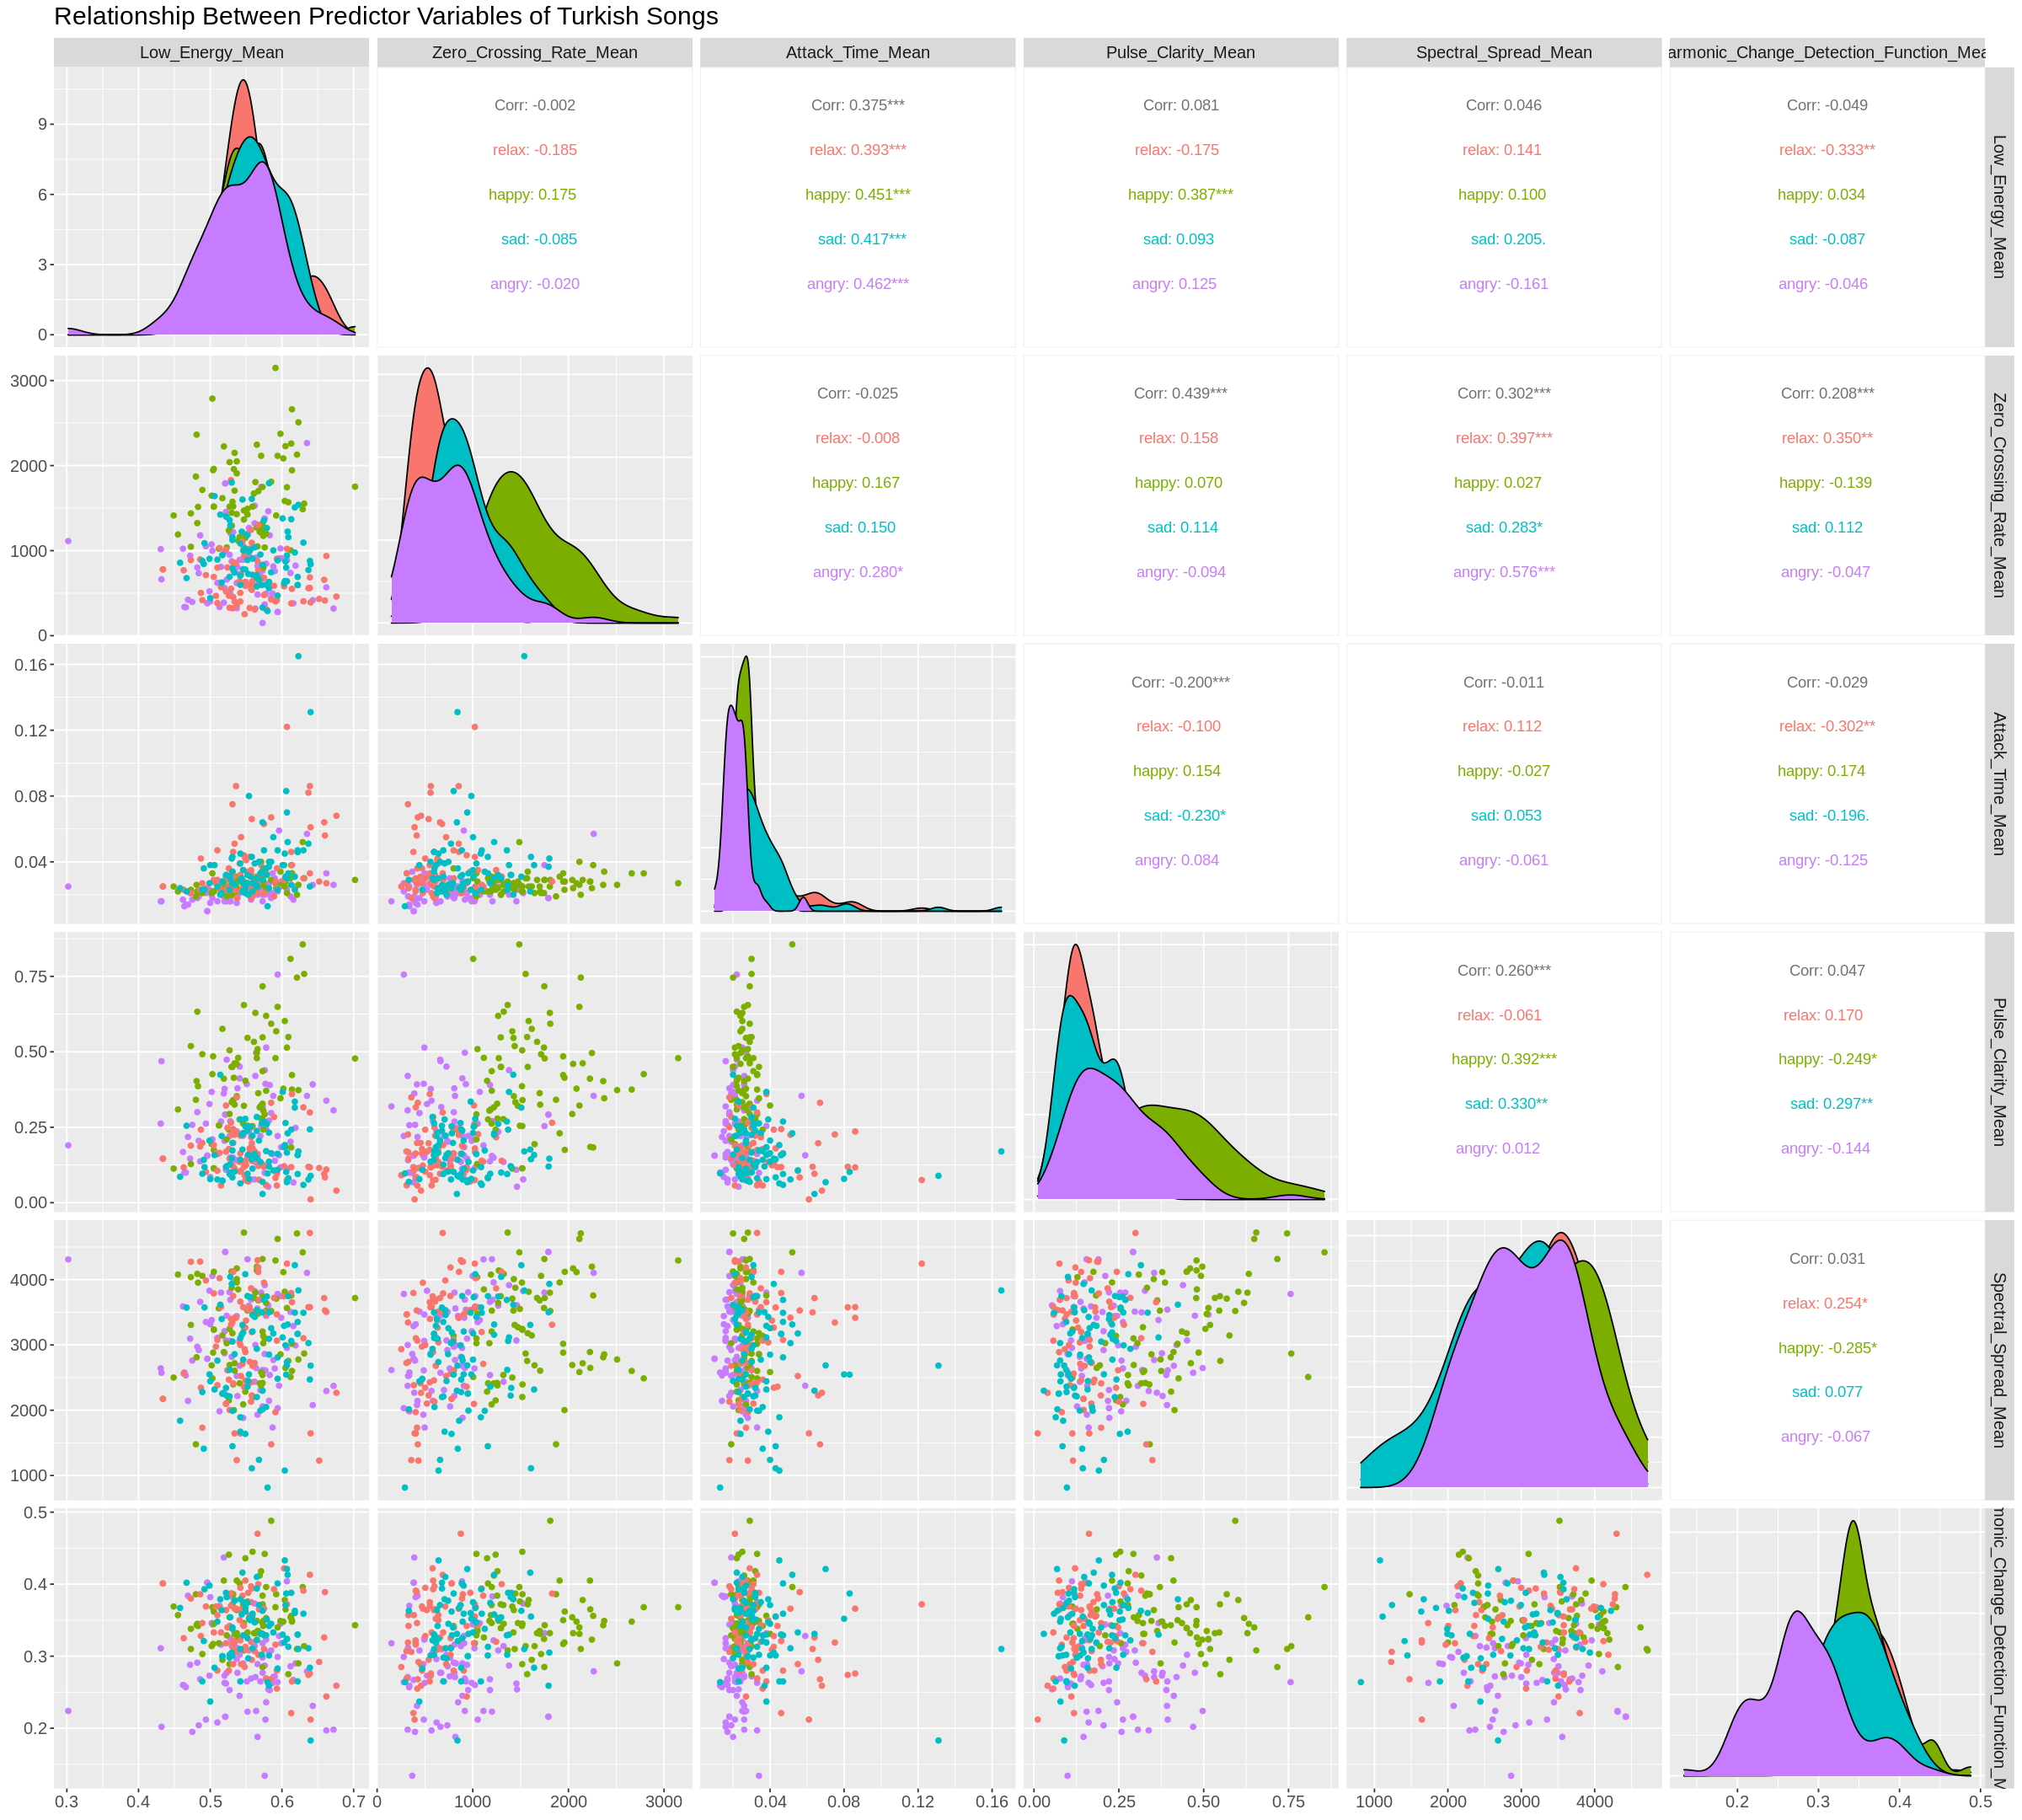

In [6]:
options(repr.plot.width = 20, repr.plot.height = 18)

turkish_small <- turkish_training |>
    select(Class, Low_Energy_Mean, Zero_Crossing_Rate_Mean, Attack_Time_Mean, 
           Pulse_Clarity_Mean, Spectral_Spread_Mean, Harmonic_Change_Detection_Function_Mean)
turkish_plot <- ggpairs(data = turkish_small, columns = 2:7, ggplot2::aes(colour=Class),
                        ggplot2::labs(tag = "Relationship Between Predictor Variables of Turkish Songs")) +
                        theme(text = element_text(size = 15))
turkish_plot

*Figure 3: ggpairs analysis for predictor variables*

#### Summarize data set
Finally, we check how many Turkish songs are in each class. We notice that every Class has 80 Turkish songs, which is very balanced. Additionally, we use group_by(), summarize(), and mean() to calculate the mean of each predictor variable.

In [7]:
check_amounts <- turkish_training |>
    group_by(Class) |>
    summarise(Count = n(),
              Mean_Low_Energy = mean(Low_Energy_Mean),
              Mean_Zero_Crossing_Rate = mean(Zero_Crossing_Rate_Mean),
              Mean_Attack_Time = mean(Attack_Time_Mean),
              Mean_Pulse_Clarity = mean(Pulse_Clarity_Mean),
              Mean_Spectral_Spread = mean(Spectral_Spread_Mean),
              Mean_Harmonic_Change_Detection_Function = mean(Harmonic_Change_Detection_Function_Mean))
check_amounts

Class,Count,Mean_Low_Energy,Mean_Zero_Crossing_Rate,Mean_Attack_Time,Mean_Pulse_Clarity,Mean_Spectral_Spread,Mean_Harmonic_Change_Detection_Function
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
relax,80,0.5555875,659.4397,0.0366375,0.1581750,3068.033,0.3369625
happy,80,0.5528250,1627.1428,0.0268875,0.4121375,3301.065,0.3544750
sad,80,0.5621750,948.5450,0.0374875,0.1675625,2806.609,0.3391125
angry,80,0.5433625,812.8233,0.0224500,0.2502625,3075.935,0.2837500


*Figure 4: Summary table of predictor variables*

Next, we selected and kept only the six predictor columns mentioned above.

In [8]:
turkish_training <- turkish_training |> select(Class, Low_Energy_Mean, 
                       Zero_Crossing_Rate_Mean, 
                       Attack_Time_Mean, 
                       Pulse_Clarity_Mean,
                       Spectral_Spread_Mean,
                       Harmonic_Change_Detection_Function_Mean)
turkish_training |> slice(1:10)

Class,Low_Energy_Mean,Zero_Crossing_Rate_Mean,Attack_Time_Mean,Pulse_Clarity_Mean,Spectral_Spread_Mean,Harmonic_Change_Detection_Function_Mean
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
angry,0.578,846.186,0.025,0.245,3445.438,0.236
angry,0.672,319.127,0.026,0.306,2373.015,0.198
angry,0.590,759.120,0.030,0.139,2639.718,0.272
angry,0.302,1112.231,0.025,0.190,4310.437,0.224
angry,0.541,725.036,0.021,0.451,3069.173,0.302
angry,0.431,1017.871,0.016,0.262,2640.316,0.311
angry,0.499,521.815,0.023,0.327,3830.596,0.273
angry,0.585,442.758,0.018,0.297,3510.867,0.308
angry,0.538,806.608,0.018,0.379,2217.058,0.277


*Figure 5: Data frame with only the chosen predictor columns*



#### Cross-Validation: Finding the Optimal K
Next, we perform cross-validation on the training set to find the optimal k number of neighbors. 

We first set up the KNN model specification, using nearest_neighbor(). We specify that we want to use straight-line distance with weight_func = "rectangular" and that we want to tune the numbers of neighbors with neighbors = tune().

In [9]:
turkish_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")


We create a recipe to preprocess the data to be standardized and balanced. This is done to minimize differences in the scale of the predictors and class imbalance.

In [10]:
turkish_recipe <- recipe(Class ~ Low_Energy_Mean + Zero_Crossing_Rate_Mean + Attack_Time_Mean + 
                         Pulse_Clarity_Mean + Spectral_Spread_Mean + Harmonic_Change_Detection_Function_Mean,
                         data = turkish_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())


Then, we create a workflow, adding the recipe and model specification. Then, we split the training data into v = 8 folds of training and validation subsets and fit the model to k = 1 to k = 50 neighbors with the tune_grid() function. The collect_metrics() function calculates the mean and standard error of the accuracy of the classification model across the folds. By filtering “accuracy”, we obtain a mean accuracy for each number of neighbors (k value). 


In [11]:
set.seed(6969)

turkish_vfold <- vfold_cv(turkish_training, v = 8, strata = Class)

gridvals <- tibble(neighbors = seq(from = 1, to = 50, by = 1))

accuracies <- workflow() |>
    add_recipe(turkish_recipe) |>
    add_model(turkish_tune) |>
    tune_grid(resamples = turkish_vfold, grid = gridvals) |>
    collect_metrics() |>
    filter(.metric == "accuracy") |>
    select(neighbors, mean)
accuracies |> arrange(desc(mean)) |>
    slice(1:5)

neighbors,mean
<dbl>,<dbl>
3,0.721875
4,0.721875
5,0.712500
6,0.700000
7,0.684375


*Figure 6: Top five k neighbors with the highest prediction accuracy*

To better visualize this, we plot the mean prediction accuracy of the model against the number of neighbors. As we can see from the Figure 7 below, k = 3 and k = 4 neighbors have the highest accuracy (tallest peak). In Figure 6 above, we see that k = 3 and 4 neighbors have the same mean prediction of 72.18%. For our final classification mode, we select the smaller k of the two, k = 3, because it is an odd number, making it easier to calculate the majority and avoid ties.


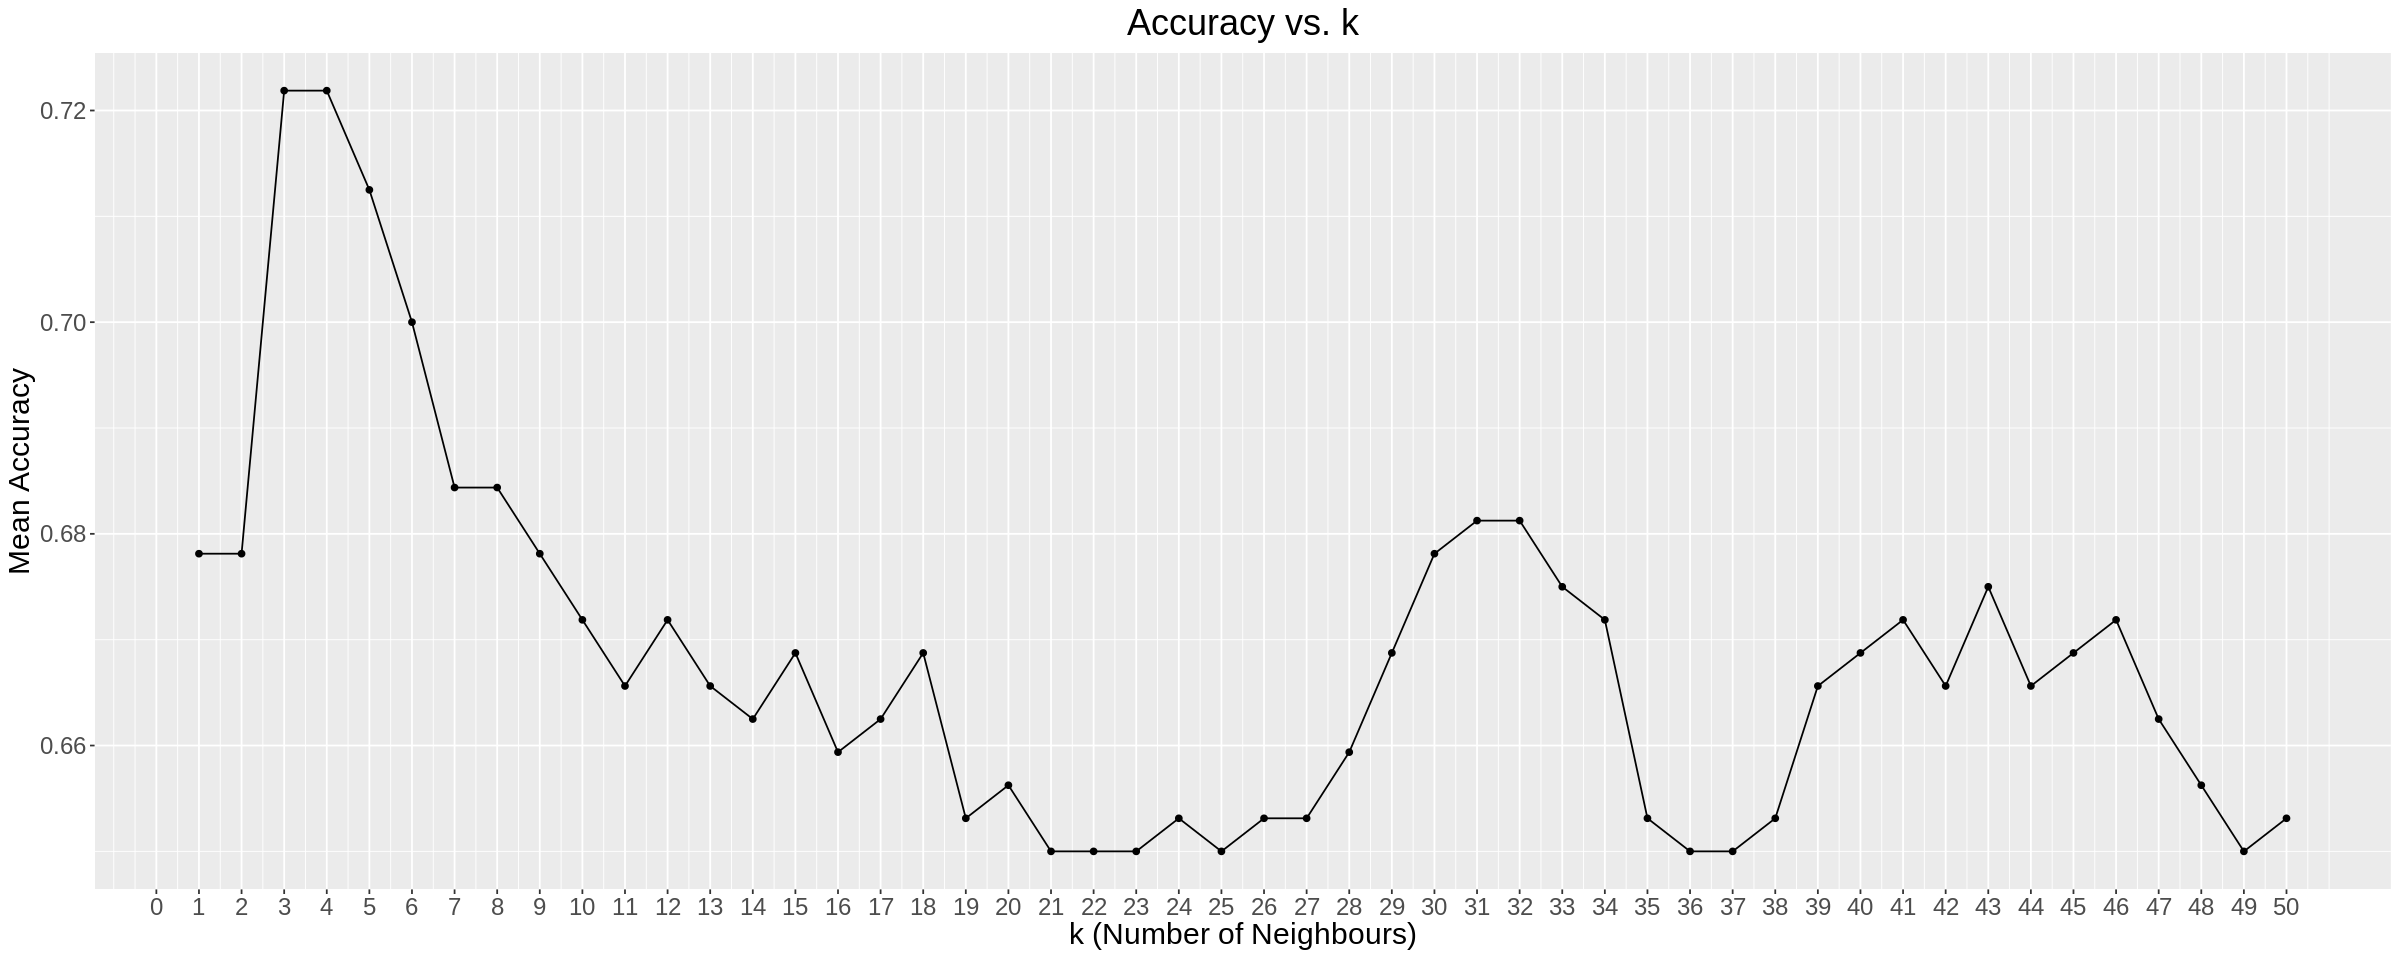

In [12]:
options(repr.plot.width = 20, repr.plot.height = 8)

accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "k (Number of Neighbours)", y = "Mean Accuracy") +
    ggtitle("Accuracy vs. k") +
    theme(text = element_text(size = 18), plot.title = element_text(hjust = 0.5), plot.tag = element_text(size = 12)) + 
    scale_x_continuous(breaks = 0:50)

accuracy_vs_k

k_min <- accuracies |>
    arrange(desc(mean)) |>
    slice(1) |>
    select(neighbors) |>
    pull()

*Figure 7: Accuracy vs. Number of Neighbors*

As you can see in the visualization, the highest accuracy peaks at about 72% at k = 3 and k = 4.

### Final Classification Model


Now that we have found the most optimal number of neighbors, we build our classifier like we did above with k = 3 as the number of neighbors. We then test the accuracy of the classifier, using it to predict the Class of the testing set. Using this data frame, we compare the actual Class vs. Predicted Class (.pred_class) using the function metrics().

In [13]:
set.seed(6969)

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) |>
    set_engine("kknn") |>
    set_mode("classification")

turkish_fit <- workflow() |>
    add_recipe(turkish_recipe) |>
    add_model(knn_spec) |>
    fit(data = turkish_training)

turkish_predictions <- predict(turkish_fit, turkish_testing) |>
    bind_cols(turkish_testing)

### Results

#### Accuracy of the Classification Model

In [14]:
turkish_accuracy <- turkish_predictions |>
    metrics(truth = Class, estimate = .pred_class) |>
    filter(.metric == "accuracy")

turkish_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.9125


*Figure 8: Accuracy of Classifier*




We calculate the statistics of the classifier with metrics(). Then filter to only see the accuracy, we get that the accuracy of our classifier is 91.25%, shown above in Figure 8.

#### Confusion Matrix

In [15]:
turkish_mat <- turkish_predictions |>
    conf_mat(truth = Class, estimate = .pred_class)

turkish_mat

          Truth
Prediction relax happy sad angry
     relax    73     0  10     2
     happy     1    79   2     0
     sad       4     1  65     3
     angry     2     0   3    75

*Figure 9: Confusion Matrix*



As seen in Figure 9 above, we created a confusion matrix to visualize our classifier’s predictions using conf_mat(). The majority of misidentified points were either relax were misclasified as either relaxed or sad, with 10 instances of “sad” music tracks being mislabelled as “relax” and 4 “relax” songs being mislabelled as “sad”. Overall, the classifier correctly predicted the class of 292/320 Turkish song, thus yielding the accuracy value of 91.25%.

#### Visualization of the Analysis

`summarise()` has grouped output by '.pred_class'. You can override using the
`.groups` argument.


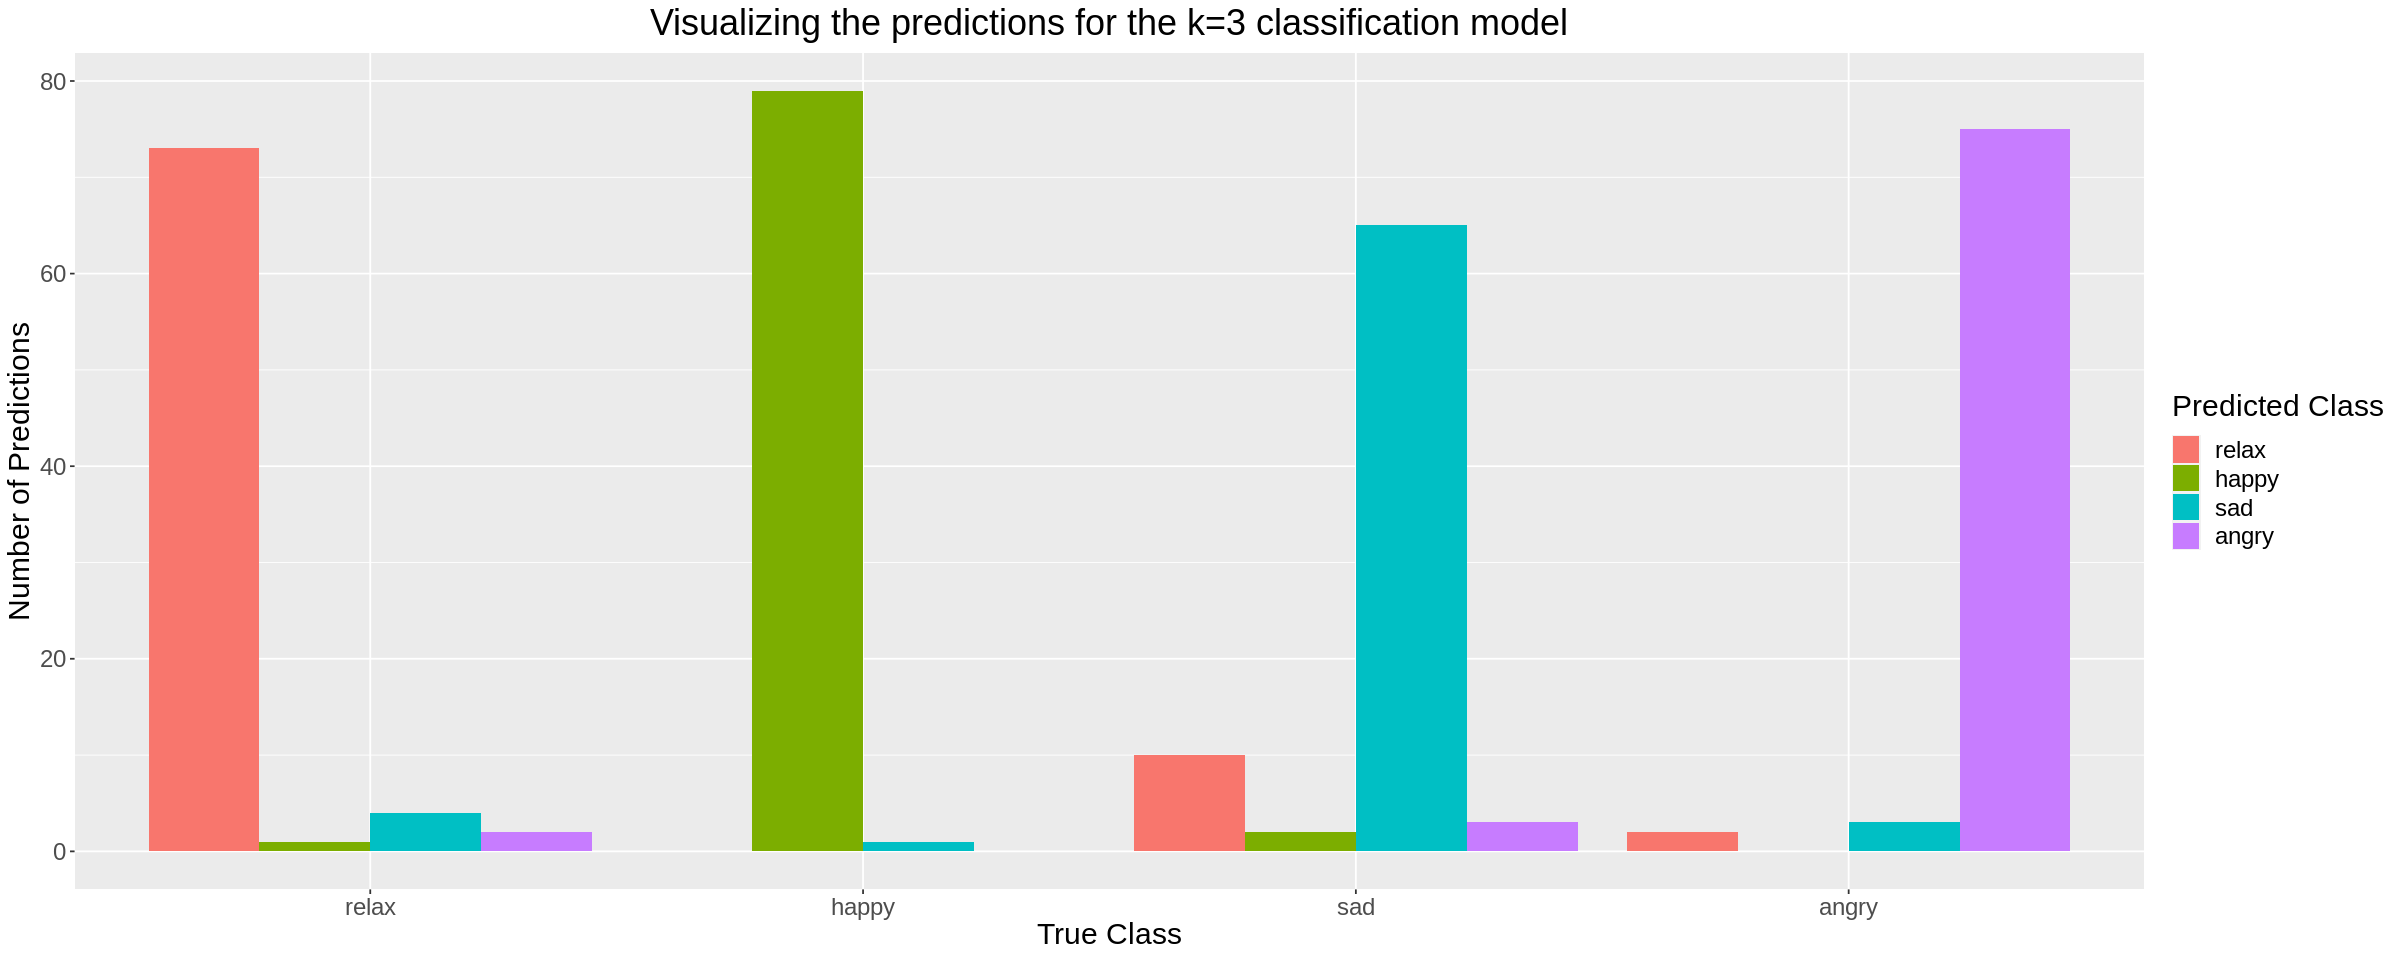

In [16]:
prediction_plot <- turkish_predictions |>
    group_by(.pred_class, Class) |>
    summarize(count = n()) |>
    ungroup() |>
    add_row(.pred_class = as.factor("relax"), Class = as.factor("happy"), count = 0) |>
    add_row(.pred_class = as.factor("angry"), Class = as.factor("happy"), count = 0) |>
    add_row(.pred_class = as.factor("happy"), Class = as.factor("angry"), count = 0) |>
    ggplot(aes(x = Class, y = count, fill = .pred_class)) +
        geom_bar(stat = "identity", position = "dodge") +
        labs(x = "True Class", y = "Number of Predictions", fill = "Predicted Class") +
        ggtitle("Visualizing the predictions for the k=3 classification model") +
        theme(text = element_text(size = 18), plot.title = element_text(hjust = 0.5))
prediction_plot


*Figure 10: Visualization of different number of neighbors*

Figure 10 above shows a bar chart to visualize the distribution of the model's predictions. We first used the group_by() and summarize() functions to find the number of times the classifier identified an observation of each Class to be one of the 4 emotions. We then used add_row() to include the cases where an observation of a certain Class was never predicted to be another specific Class, such as with "happy" songs never being classified as "angry". Lastly, we used ggplot() to create a bar chart and used position = "dodge" to group the bars based on their true Class. This visualization confirms that the classifier did the best job at predicted songs that were "happy" and had more difficulty with songs that were "sad".

## Discussion

### Summary
We found that a k-nearest neighbor classifier with the predictors Low Energy, Zero Crossing Rate, Attack Time, Pulse Clarity, Spectral Spread, and Harmonic Change Detection and with k = 3 neighbors accurately predicts the Emotion of a Turkish song 91.25% of the time. As music classification is mostly for recreational use and does not involve serious life or death or monetary repercussions, the accuracy of 91.25% by our classifier will suffice. 

In Figure 9 and 10, we observe that happy and angry songs were misidentified the least, and a happy song was never classified as a mad song and vice versa. Thus, our classifier is able to accurately distinguish between happy and angry songs. We also observe that the classifier falsely classified the class of a song only 28 out of 320 times (Figure 9), so the classifier misclassifies songs 8.75% of the time. We found that relaxed songs were misidentified the most at 12 times (out of 28 misidentifications). Relaxed Turkish songs were falsely classified as sad songs 10 out of those 12 times. Additionally, sad songs were misidentified the second most at 9 times, and they were falsely classified as relaxed songs 4 out of those 8 times. This suggests some similarities between relaxed and sads songs. Furthermore, we observe that both happy and angry songs were misidentified as sad songs, suggesting that our classifier is the least accurate in distinguishing sad songs from the other songs.

Our classifier worked well because as seen in Figure 3 (ggpairs plot), our predictors were not too closely related yet certain ranges of values of the predictors are associated with one of the four emotions (ex. one color is clustered in the higher values of a variable). We also set the seed when necessary to prevent random errors and enable reproducibility. Additionally, we standardized the data to minimize inbalances in a predictor's vote in the calculation of straight-line distance. Additionally, since we used cross-validation and calculated the accuracy of each k a reasonable number of times, the k-value we chose, k = 3, does not overfit nor underfit the data.

Overall, we have been able to support our hypothesis that with using these variables, we can accurately classify a Turkish song into the four emotions of Happy, Sad, Relaxed, and Angry.

### Impact and Future Research
In this project, we expected to build a robust model that can accurately predict a listener’s emotional response given a Turkish song’s characteristics. Many music-sharing websites often group songs together via genre to create auto-generated playlists for their users. Our model could provide an alternative grouping method more focused on matching a group of songs that invoke specific emotions. Additionally, this can be used for listeners to quickly find songs that fit their desired mood. 

In the future, this project could lead to questioning which primary emotions a given song should be categorized into. Here, we categorized songs into the emotions of Happy, Sad, Angry, and Relaxed, but can we also categorize songs into Dreamy or Energizing with the characteristics used in the project? It could also lead to different genre definitions that more closely align with how music makes the listener feel. Additionally, it leads to the question of what characteristics of a song can predict a song’s emotion with the highest efficiency and accuracy. In our findings, we observe that relaxed songs were misidentified as sad songs more frequently than the other emotions, implying that it may be a little difficult to distinguish between these two emotions with the variables we used in our model. What characteristics make these two emotions similar? What song characteristics can best set similar yet distinct emotions apart? Lastly, this project may raise the question of whether our model of categorizing a song's emotion is unique to Turkish music or generalizable across cultures. 


## References

Cowen, A. S., Fang, X., Sauter, D., & Keltner, D. (2020). What music makes us feel: At least 13 dimensions organize subjective experiences associated with music across different cultures. Proceedings of the National Academy of Sciences, 117(4), 1924–1934. https://doi.org/10.1073/pnas.1910704117

Er, M. B., Çiğ, H., & Aydilek, İ. B. (2021). A new approach to recognition of human emotions using brain signals and music stimuli. Applied Acoustics, 175, 107840. https://doi.org/10.1016/j.apacoust.2020.107840

Oxford Learner’s Dictionaries | Find definitions, translations, and grammar explanations at Oxford Learner’s Dictionaries. (n.d.). Retrieved April 11, 2023, from https://www.oxfordlearnersdictionaries.com/us/

### Data Set
Bilal Er, M., & Aydilek, I. B. (2019). Music emotion recognition by using chroma spectrogram and deep visual features. Journal of Computational Intelligent Systems, 12(2), 1622â€“1634. International Journal of Computational Intelligence Systems